In [47]:
import pandas            as pd
import pandasql          as psql
import numpy             as np
import os
import datetime
import time
import math
import IPython

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


%matplotlib inline


sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

from   IPython.core.display           import display, HTML
from   decimal                        import Decimal


print('Setting is done:')


#------------------------------------
print('Make the notebook html as wide as possible')
display(HTML("<style>.container { width:100% !important; }</style>"))
print()

script_dir = os.getcwd()
print(script_dir)

Setting is done:
Make the notebook html as wide as possible



G:\Meine Ablage\price_anomaly_detection


In [48]:
df = pd.read_csv(script_dir +'/TSLA.CSV/')

In [49]:
# train, test = train_test_split(df,train_size = 0.80, random_state = 1236)

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2109, 7) (528, 7)


In [50]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])


train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

In [51]:
def create_dataset(X, y, timestep=1):
    Xs, ys = [], []
    for i in range(len(X) - timestep):
        v = X.iloc[i:(i + timestep)].values
        Xs.append(v)        
        ys.append(y.iloc[i + timestep])
    return np.array(Xs), np.array(ys)

In [52]:
print(train.shape)

time_steps = 7

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)

print(X_train.shape)

X, y = create_dataset(df[['Close']], df.Close, time_steps)


(2109, 7)
(2102, 7, 1)


In [53]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])


model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 1)              129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [55]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
60/60 [==============================] - 14s 64ms/step - loss: 0.5399 - val_loss: 0.1771
Epoch 2/100
60/60 [==============================] - 2s 27ms/step - loss: 0.1884 - val_loss: 0.1679
Epoch 3/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0882 - val_loss: 0.1219
Epoch 4/100
60/60 [==============================] - 2s 27ms/step - loss: 0.0818 - val_loss: 0.1186
Epoch 5/100
60/60 [==============================] - 2s 37ms/step - loss: 0.1012 - val_loss: 0.2025
Epoch 6/100
60/60 [==============================] - 2s 27ms/step - loss: 0.1720 - val_loss: 0.1397
Epoch 7/100
60/60 [==============================] - 2s 28ms/step - loss: 0.1240 - val_loss: 0.1750


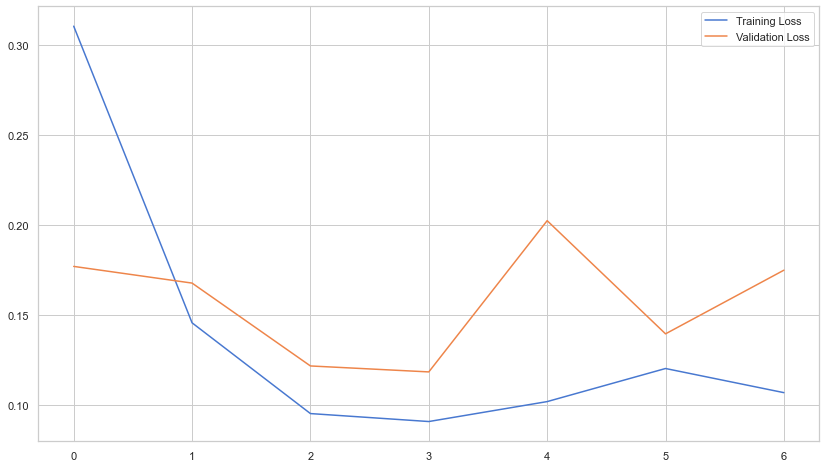

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [57]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 11ms/step - loss: 3.3231


3.3231277465820312

C:\Users\Anahita Raulin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

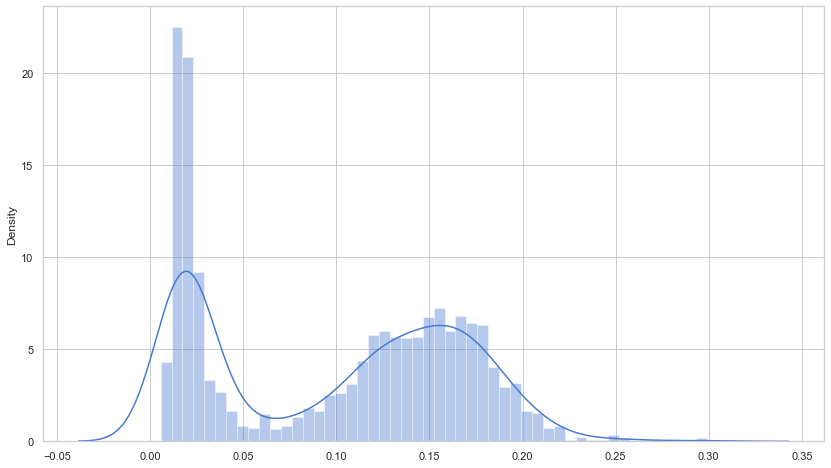

In [58]:
# plot training loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True)

C:\Users\Anahita Raulin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



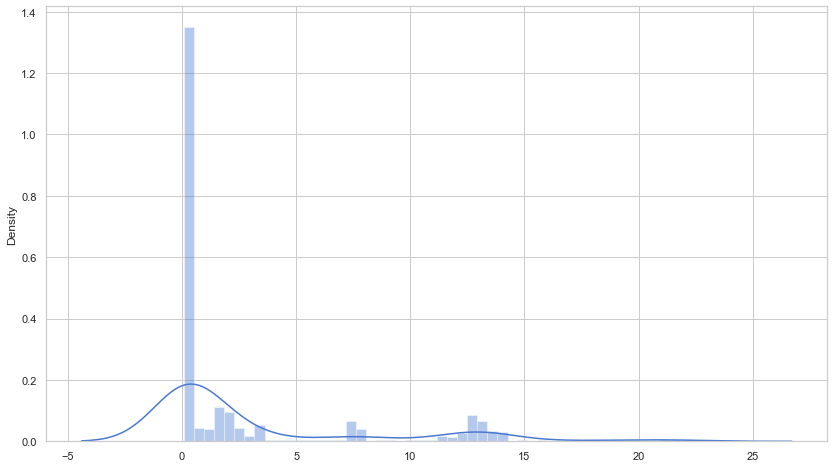

In [59]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

sns.distplot(test_mae_loss, bins=50, kde=True);

In [64]:
THRESHOLD = 8
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[time_steps:].Close

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [66]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
2552,2020-08-18,379.798004,384.779999,369.022003,15.074974,377.417999,82372500,8.017140,8,True
2553,2020-08-19,373.000000,382.200012,368.242004,14.999830,375.705994,61026500,8.565704,8,True
2554,2020-08-20,372.135986,404.398010,371.411987,16.082225,400.365997,103059000,9.148056,8,True
2555,2020-08-21,408.951996,419.097992,405.010010,16.504912,409.996002,107448000,9.934591,8,True
2556,2020-08-24,425.256012,425.799988,385.503998,16.190816,402.839996,100318000,10.564054,8,True


In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:].Close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.Date, y=scaler.inverse_transform(anomalies.Close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
#lefin